In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# inspiration for data preprocessing is taken from Erin Conway's notebook: 
# "https://www.kaggle.com/code/eward96/age-and-gender-prediction-on-utkface/notebook"

In [18]:
#make sure you have a "\" at the end of the path name:
dataset_path = input("Please enter the path to the dataset folder (ending in .../crop_part1/): ")

Please enter the path to the dataset folder (ending in .../crop_part1/):  C:\Users\nimda~\Documents\TXAI\code\finproj\data\crop_part1\


In [39]:
images = []
ages = []
genders = []
ethnicities = []

for i in os.listdir(dataset_path)[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    ethnicities.append(int(split[2]))
    images.append(Image.open(os.path.join(dataset_path + i)))

In [ ]:
#one file name misses an ethnicity value and one file name missed a gender value, this is fixed manually

In [40]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')
ethnicities = pd.Series(list(ethnicities), name='Ethnicities')

df = pd.concat([images, ages, genders, ethnicities], axis=1)

Images  Ages  Genders  \
0     <PIL.JpegImagePlugin.JpegImageFile image mode=...   100        1   
1     <PIL.JpegImagePlugin.JpegImageFile image mode=...   100        1   
2     <PIL.JpegImagePlugin.JpegImageFile image mode=...   101        1   
3     <PIL.JpegImagePlugin.JpegImageFile image mode=...    10        0   
4     <PIL.JpegImagePlugin.JpegImageFile image mode=...    10        0   
...                                                 ...   ...      ...   
7995  <PIL.JpegImagePlugin.JpegImageFile image mode=...    63        1   
7996  <PIL.JpegImagePlugin.JpegImageFile image mode=...    63        1   
7997  <PIL.JpegImagePlugin.JpegImageFile image mode=...    63        1   
7998  <PIL.JpegImagePlugin.JpegImageFile image mode=...    63        1   
7999  <PIL.JpegImagePlugin.JpegImageFile image mode=...    63        1   

      Ethnicities  
0               0  
1               2  
2               2  
3               0  
4               0  
...           ...  
7995            0  
7996            0  
7997            0  
7998            0  
7999            0  

[8000 rows x 4 columns]

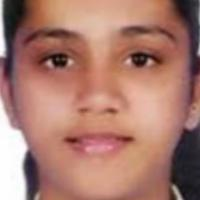

14 1 3


In [43]:
id = 513
display(df['Images'][id])
print(df['Ages'][id], df['Genders'][id], df['Ethnicities'][id])

<Axes: xlabel='Ages', ylabel='Count'>

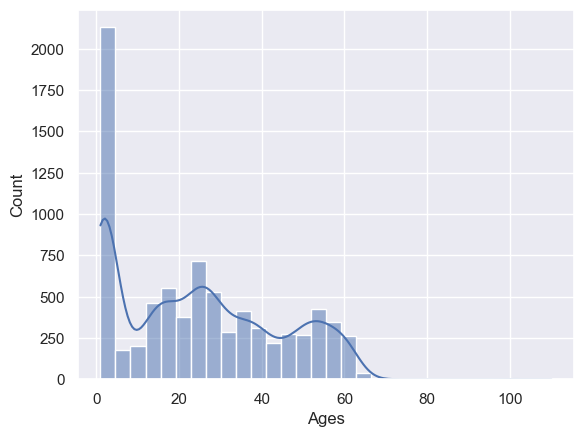

In [45]:
sns.set_theme()
sns.histplot(df['Ages'],kde=True, bins=30)

In [ ]:
#quite skewed toward younger faces

In [53]:
x = []
y = []

for i in range(len(df)):
    #df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.Resampling.LANCZOS)
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200, 200), Image.Resampling.LANCZOS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i]), int(df['Ethnicities'].iloc[i])]
    y.append(agegen)
x = np.array(x)

C:\Users\nimda~\AppData\Local\Temp\ipykernel_12404\2233040871.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Images'].iloc[i] = df['Images'].iloc[i].resize((200, 200), Image.Resampling.LANCZOS)
C:\Users\nimda~\AppData\Local\Temp\ipy

In [54]:
x = []
y = []

for i in range(len(df)):
    img = df['Images'].iloc[i].resize((200, 200), Image.Resampling.LANCZOS)
    df.at[i, 'Images'] = img  # Use .at to safely assign the resized image
    ar = np.asarray(img)
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i]), int(df['Ethnicities'].iloc[i])]
    y.append(agegen)

x = np.array(x)

In [56]:
x

array([[[[219, 223, 226],
         [232, 235, 240],
         [232, 237, 243],
         ...,
         [226, 233, 241],
         [219, 226, 234],
         [220, 227, 235]],

        [[228, 232, 235],
         [236, 239, 244],
         [230, 234, 243],
         ...,
         [224, 231, 239],
         [220, 227, 235],
         [220, 227, 235]],

        [[233, 236, 241],
         [236, 239, 244],
         [226, 230, 239],
         ...,
         [220, 227, 235],
         [221, 228, 236],
         [219, 226, 234]],

        ...,

        [[ 25,  47,  88],
         [ 35,  59, 103],
         [ 35,  67, 116],
         ...,
         [171, 175, 178],
         [182, 183, 187],
         [184, 188, 191]],

        [[ 27,  50,  92],
         [ 22,  49,  92],
         [ 18,  49,  96],
         ...,
         [254, 255, 255],
         [255, 255, 255],
         [254, 255, 255]],

        [[ 22,  47,  88],
         [  9,  36,  79],
         [  3,  34,  80],
         ...,
         [253, 253, 251],
        

In [197]:
#y_age = df['Ages']
#y_gender = df['Genders']
#y_ethnicity = df['Ethnicities']

#x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
#x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)
#x_train_ethnicity, x_test_ethnicity, y_train_ethnicity, y_test_ethnicity(x, y_ethnicity, test_size=0.2, stratify=y_ethnicity)

# error in train_test_split: least populated class in y has only 1 member

In [198]:
print(y_age.value_counts())
print(y_gender.value_counts())
print(y_ethnicity.value_counts())

#age seems to be the problem

Ages
1      1112
2       475
3       284
26      279
4       260
       ... 
33       46
63       39
44       27
110       2
100       2
Name: count, Length: 61, dtype: int64
Genders
1    4398
0    3601
Name: count, dtype: int64
Ethnicities
0    3941
2    1392
3    1320
4    1029
1     317
Name: count, dtype: int64


In [199]:
#remove singleton age datapoint

indices_to_remove = y_age[y_age == 101].index
x_train = np.delete(x, indices_to_remove, axis=0)
y_age = y_age.drop(indices_to_remove)
y_gender = y_gender.drop(indices_to_remove)
y_ethnicity = y_ethnicity.drop(indices_to_remove)
print(y_age.value_counts())

Ages
1      1112
2       475
3       284
26      279
4       260
       ... 
33       46
63       39
44       27
110       2
100       2
Name: count, Length: 61, dtype: int64


In [200]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x_filtered, y_age_filtered, test_size=0.2, stratify=y_age_filtered)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x_filtered, y_gender_filtered, test_size=0.2, stratify=y_gender_filtered)
x_train_ethnicity, x_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(x_filtered, y_ethnicity_filtered, test_size=0.2, stratify=y_ethnicity_filtered)

In [220]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, age_labels, gender_labels, ethnicity_labels, transform=None):
        self.images = images
        self.age_labels = y_age
        self.gender_labels = y_gender
        self.ethnicity_labels = y_ethnicity
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        print("debug 1")
        image = self.images[idx]
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
            
        print("debug 2.0")

        #this is where something seems to go wrong when idx == 2
        age = self.age_labels[idx]
        print("debug 2.1")
        gender = self.gender_labels[idx]
        print("debug 2.2")
        ethnicity = self.ethnicity_labels[idx]
        print("debug 2.3")

        
        if self.transform:
            image = self.transform(image)
        print("debug 3")

        # Print type and shape after transformation to confirm it's a tensor
        print(f"Image type after transform: {type(image)}")
        print(f"Image shape after transform: {image.shape}")

        return image, age, gender, ethnicity

In [221]:
dataset = CustomDataset(x_train, y_train_age, y_train_gender, y_train_ethnicity, transform=transform)

In [182]:
print(f"Length of age_labels: {len(y_age)}")
print(f"Length of age_labels: {len(age_labels)}")
print(f"Length of gender_labels: {len(y_gender)}")
print(f"Length of ethnicity_labels: {len(y_ethnicity)}")

Length of age_labels: 7999
Length of age_labels: 7999
Length of gender_labels: 7999
Length of ethnicity_labels: 7999


In [224]:
example_index = 0
example_item = dataset[example_index]
print(f"Example item: {example_item}")

debug 1
debug 2.0
debug 2.1
debug 2.2
debug 2.3
debug 3
Image type after transform: <class 'torch.Tensor'>
Image shape after transform: torch.Size([3, 200, 200])
Example item: (tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2

In [215]:
inputs, labels_age, labels_gender, labels_ethnicity = example_item
print(f"Inputs: {inputs}")
print(f"Labels (age): {labels_age}")
print(f"Labels (gender): {labels_gender}")
print(f"Labels (ethnicity): {labels_ethnicity}")

Inputs: tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044, 

In [225]:
idx = 2

age_labels = y_age_filtered
age_labels[idx]

KeyError: 2

In [186]:
for i in range(5):  # Check the first 5 items
    item = dataset[i]
    if isinstance(item, tuple):
        print(f"Item {i} is a tuple!")
        print(f"Element 0 (input image) type: {type(item[0])}, shape: {item[0].shape if hasattr(item[0], 'shape') else len(item[0])}")
        print(f"Element 1 (age label) type: {type(item[1])}, value: {item[1]}")
        print(f"Element 2 (gender label) type: {type(item[2])}, value: {item[2]}")
        print(f"Element 3 (ethnicity label) type: {type(item[3])}, value: {item[3]}")
    else:
        print(f"Item {i} is NOT a tuple!")

1
2
2.1
2.2
3
Image type after transform: <class 'torch.Tensor'>
Image shape after transform: torch.Size([3, 200, 200])
Item 0 is a tuple!
Element 0 (input image) type: <class 'torch.Tensor'>, shape: torch.Size([3, 200, 200])
Element 1 (age label) type: <class 'numpy.int64'>, value: 100
Element 2 (gender label) type: <class 'numpy.int64'>, value: 1
Element 3 (ethnicity label) type: <class 'numpy.int64'>, value: 0
1
2
2.1
2.2
3
Image type after transform: <class 'torch.Tensor'>
Image shape after transform: torch.Size([3, 200, 200])
Item 1 is a tuple!
Element 0 (input image) type: <class 'torch.Tensor'>, shape: torch.Size([3, 200, 200])
Element 1 (age label) type: <class 'numpy.int64'>, value: 100
Element 2 (gender label) type: <class 'numpy.int64'>, value: 1
Element 3 (ethnicity label) type: <class 'numpy.int64'>, value: 2
1
2


KeyError: 2

In [119]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# CustomDataset to load training and testing data
train_dataset = CustomDataset(x_filtered, y_train_age, y_train_gender, y_train_ethnicity, transform=transform)
test_dataset = CustomDataset(x_filtered, y_test_age, y_test_gender, y_test_ethnicity, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [120]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=1, output_type='regression'):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 25 * 25, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
        self.output_type = output_type
        if self.output_type == 'regression':
            self.fc2 = nn.Linear(64, 1)  # For age regression
        else:
            self.fc2 = nn.Linear(64, num_classes)  # For binary classification (gender or ethnicity)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 128 * 25 * 25)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        if self.output_type == 'regression':
            return x  # Age regression (no activation function)
        else:
            return torch.sigmoid(x)  # For gender/ethnicity classification

In [121]:
def get_loss_function(output_type):
    if output_type == 'regression':
        return nn.MSELoss()
    else:
        return nn.BCELoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [190]:
# For Age model (regression)
model_age = CNNModel(num_classes=1, output_type='regression')
criterion_age = get_loss_function('regression')

# For Gender model (classification)
model_gender = CNNModel(num_classes=1, output_type='classification')
criterion_gender = get_loss_function('classification')

# For Ethnicity model (classification)
model_ethnicity = CNNModel(num_classes=5, output_type='classification')  # Assuming 5 ethnicities
criterion_ethnicity = get_loss_function('classification')

# Training loop for age, gender, and ethnicity
def train_model(model, criterion, optimizer, dataloader, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for inputs, y_age_filtered, y_gender_filtered, y_ethnicity_filtered in dataloader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            if model.output_type == 'regression':
                loss = criterion(outputs, labels_age.float())
            else:
                loss = criterion(outputs.view(-1), labels_gender.float())  # or ethnicity
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}')
        
# Train models
train_model(model_age, criterion_age, optimizer, train_loader, num_epochs=50)
train_model(model_gender, criterion_gender, optimizer, train_loader, num_epochs=50)
train_model(model_ethnicity, criterion_ethnicity, optimizer, train_loader, num_epochs=50)

hi!


KeyError: 2694